In [43]:
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np
import geopandas as gpd
import skimage as skm
from skimage import exposure
from skimage.util import img_as_float
from rasterio import features
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

In [44]:
walrus_mres_dir = os.path.abspath("../../")
# "C:\\Users\\Student\\Documents\\101_walrus_mres\\

# Create path to the image file 
image_path = os.path.join(walrus_mres_dir, "planet_skysat_pairs", "planet_skysat_pairs", "torellneset_psscene_analytic_8b_sr_udm2", "PSScene", "20230824_113933_07_2438_3B_AnalyticMS_SR_8b_harmonized_clip.tif")


In [45]:
# Try opening the TIFF file
try:
    with rasterio.open(image_path) as img:
        bands = img.read()  # Read all bands
        transform = img.transform  # Get transform for coordinate conversion
except rasterio.errors.RasterioIOError:
    print(f"Error: Unable to open file {image_path}")

In [36]:
# Load the shapefiles
shapefiles_path = "C:\\Users\\Student\\Documents\\101_walrus_mres\\GIS\\torellneset_train_08.shp"

In [47]:
# Function for plotting
def make_plotting_array(full_arr, percent_clip=2):
    rgb_arr = np.array([full_arr[2], full_arr[1], full_arr[0]])
    p1, p2 = np.percentile(rgb_arr, (percent_clip, 100-percent_clip))
    rgb_rescale = exposure.rescale_intensity(rgb_arr, in_range=(p1, p2))
    return rgb_rescale.transpose(1, 2, 0)

# Function for plotting
def colour_stretch(image, index, minmax=(0, 10000)):
    colours = image[:, :, index].astype(np.float64)
    max_val = minmax[1]
    min_val = minmax[0]
    
    colours[colours > max_val] = max_val
    colours[colours < min_val] = min_val
    
    for b in range(colours.shape[2]):
        colours[:, :, b] = colours[:, :, b] * 1 / (max_val - min_val)
        
    return colours

# Function to define labels and raster mask
def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)
    shp_df['Label'] = shp_df['Label'].map({'ocean': 1, 'land': 2, 'walrus': 3})
    
    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['Label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

# Funciton for plotting 
def get_prediction_colourmap(pred_array):
    labels = {0: "NoData", 1: "ocean", 2: "land", 3: "walrus"}
    cmap = {0: "gray", 1: "lightskyblue", 2: "green", 3: "red"}
    patches = [mpatches.Patch(color=cmap[i], label=labels[i]) for i in cmap]
    cmap = ListedColormap(cmap.values())
    colour_range = (min(labels), max(labels))
    return cmap, patches, colour_range

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


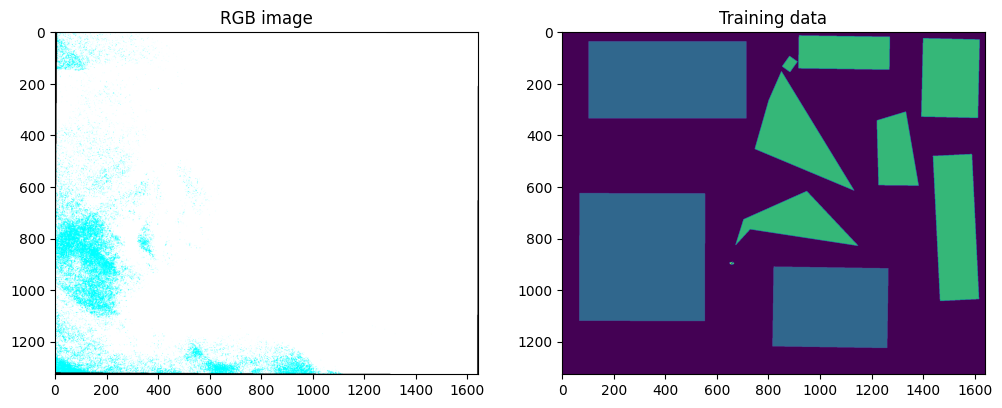

In [48]:
# Plot the orginal image and the shapefile 
img, roi = get_raster_and_mask(image_path, shapefiles_path)

plt.figure(figsize=(12, 12))
plt.subplot(121)
plt.imshow(make_plotting_array(img))
plt.title("RGB image")

plt.subplot(122)
plt.imshow(roi)
plt.title("Training data")
plt.show()

In [49]:
# Prepare training data
img = img.transpose(1, 2, 0)
n_samples = (roi > 0).sum()
labels = np.unique(roi[roi > 0])
print(f"We have {n_samples} samples")
print(f"The training data includes {labels.size} classes: {labels}")

We have 908755 samples
The training data includes 3 classes: [1 2 3]


In [50]:
# Prepare the training data and print the matrix size
X = img[roi > 0, :]
y = roi[roi > 0]

print(f"X matrix size: {X.shape}")
print(f"y array size: {y.shape}")

X matrix size: (908755, 8)
y array size: (908755,)


In [51]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
print(f"X_train matrix size: {X_train.shape}")
print(f"X_test matrix size: {X_test.shape}")

# Train Random Forest model
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf = rf.fit(X_train, y_train)
print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")

# Feature importance
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08"]
for b, b_name, imp in zip(range(len(band_names)), band_names, rf.feature_importances_):
    print(f"Band {b} ({b_name}) importance: {imp:.4f}")

X_train matrix size: (681566, 8)
X_test matrix size: (227189, 8)
Our OOB prediction of accuracy is: 100.00%
Band 0 (B01) importance: 0.0000
Band 1 (B02) importance: 0.0418
Band 2 (B03) importance: 0.0878
Band 3 (B04) importance: 0.1521
Band 4 (B05) importance: 0.2040
Band 5 (B06) importance: 0.2282
Band 6 (B07) importance: 0.1761
Band 7 (B08) importance: 0.1100


In [52]:
# Predictions
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img.reshape(new_shape)
print(f"Reshaped from {img.shape} to {img_as_array.shape}")

class_prediction = rf.predict(img_as_array)
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (1327, 1640, 8) to (2176280, 8)


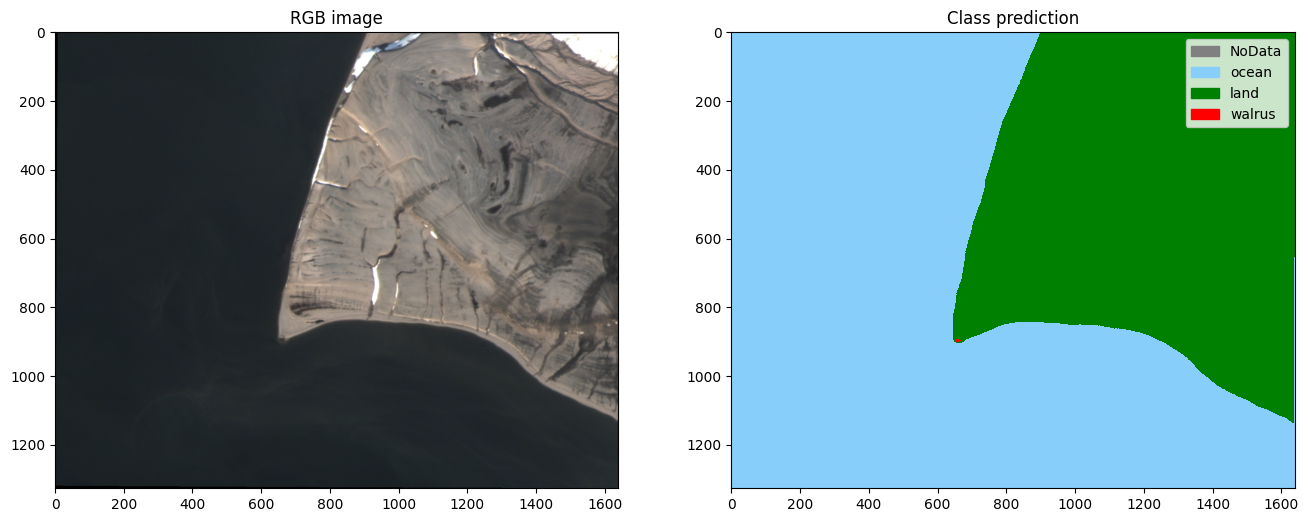

In [54]:
# Plot original image and the predicted classes
img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title("RGB image")

plt.subplot(122)
plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
plt.legend(handles=patches)
plt.title("Class prediction")
plt.show()


In [70]:
# Extract spectral values for each class
ocean_pixels = X_train[y_train == 1]
land_pixels = X_train[y_train == 2]
walrus_pixels = X_train[y_train == 3]

In [71]:
# Compute mean spectral reflectance for each class
ocean_mean = np.mean(ocean_pixels, axis=0)
land_mean = np.mean(land_pixels, axis=0)
walrus_mean = np.mean(walrus_pixels, axis=0)

# Compute standard deviation for each class
ocean_std = np.std(ocean_pixels, axis=0)
land_std = np.std(land_pixels, axis=0)
walrus_std = np.std(walrus_pixels, axis=0)

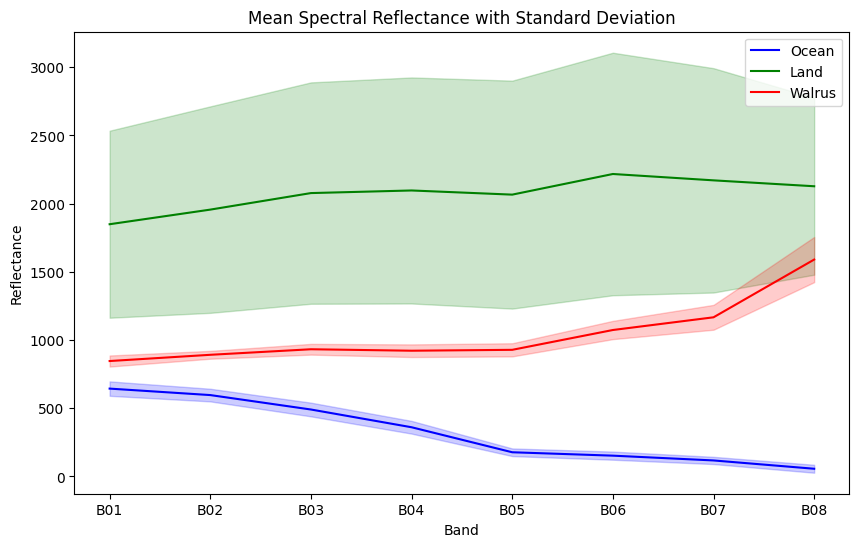

In [72]:
# Plot mean spectral reflectance for each class with standard deviation
plt.figure(figsize=(10, 6))
plt.plot(band_names, ocean_mean, label='Ocean', color='blue')
plt.fill_between(band_names, ocean_mean - ocean_std, ocean_mean + ocean_std, color='blue', alpha=0.2)

plt.plot(band_names, land_mean, label='Land', color='green')
plt.fill_between(band_names, land_mean - land_std, land_mean + land_std, color='green', alpha=0.2)

plt.plot(band_names, walrus_mean, label='Walrus', color='red')
plt.fill_between(band_names, walrus_mean - walrus_std, walrus_mean + walrus_std, color='red', alpha=0.2)

plt.title('Mean Spectral Reflectance with Standard Deviation')
plt.xlabel('Band')
plt.ylabel('Reflectance')
plt.legend()
plt.show()

The values of reflectance can range from 0 to 1 or from 0% to 100%, depending on the convention used. A value of 0 represents complete absorption of light (no reflection), while a value of 1 or 100% represents complete reflection (all incident light is reflected).

Since I'm working with satellite imagery, the reflectance values are often normalised or rescaled to a specific range, such as 0 to 1 or 0 to 10000. These values are usually obtained through calibration processes applied to the raw sensor data.

Therefore "Reflectance" on the y-axis represents the magnitude of reflected light from the surface, expressed in the units specified by the normalization or rescaling process. These units might not have a direct physical interpretation like percentage reflectance, but they still provide a relative measure of how much light is reflected by different surfaces at different wavelengths (bands).

This is me trying to debug 

In [74]:
import joblib 

In [62]:
# Train Random Forest model
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rf = rf.fit(X_train, y_train)
print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")

# Save the trained model to disk
joblib.dump(rf, 'random_forest_model.pkl')
print("Random Forest model saved.")

# Feature importance
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08"]
for b, b_name, imp in zip(range(len(band_names)), band_names, rf.feature_importances_):
    print(f"Band {b} ({b_name}) importance: {imp:.4f}")

# ... existing code ...

# Load the saved model from disk
rf_loaded = joblib.load('random_forest_model.pkl')
print("Random Forest model loaded.")

# Predictions
# Assuming img is your image data
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img.reshape(new_shape)
print(f"Reshaped from {img.shape} to {img_as_array.shape}")

class_prediction = rf_loaded.predict(img_as_array)
class_prediction = class_prediction.reshape(img[:, :, 0].shape)
# Visualization
img_rgb = colour_stretch(img, [2, 1, 0], (0, 4000))
pred_cmap, patches, c_range = get_prediction_colourmap(class_prediction)

plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(img_rgb)
plt.title("RGB image")

plt.subplot(122)
plt.imshow(class_prediction, cmap=pred_cmap, vmin=c_range[0], vmax=c_range[1])
plt.legend(handles=patches)
plt.title("Class prediction")
plt.show()


IndexError: boolean index did not match indexed array along dimension 1; dimension is 1327 but corresponding boolean dimension is 3

this is using a clipped image for testing 

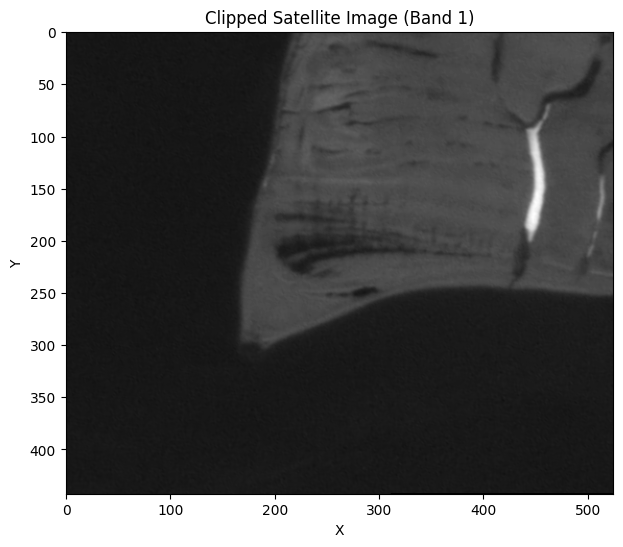

In [82]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Create path to the image file 
image_path = "C:\\Users\\Student\\Documents\\101_walrus_mres\\planet_skysat_pairs\\planet_skysat_pairs\\torellneset_psscene_analytic_8b_sr_udm2\\PSScene\\20230824_113933_07_2438_3B_AnalyticMS_SR_8b_harmonized_clip.tif"

# Create path to the shapefile 
shape_path = "C:\\Users\\Student\\Documents\\101_walrus_mres\\GIS\\torell_0824_113933_clip.shp"

# Function to clip the image by shape
def clip_image(image_path, shape_path):
    # Read the shapefile
    shapefile = gpd.read_file(shape_path)
    
    # Open the satellite image
    with rasterio.open(image_path) as src:
        # Perform the clipping
        out_image, out_transform = mask(src, shapes=shapefile.geometry, crop=True)
        
        # Update metadata for the new clipped image
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
    
    return out_image, out_meta

# Clip the image
clipped_image, clipped_meta = clip_image(image_path, shape_path)

# Plot one or more bands of the clipped image for visualization
plt.figure(figsize=(8, 6))
plt.imshow(clipped_image[0], cmap='gray')  # Plotting the first band
plt.title('Clipped Satellite Image (Band 1)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Save the clipped image
with rasterio.open("clipped_image.tif", "w", **clipped_meta) as dest:
    dest.write(clipped_image)


In [88]:
import numpy as np
from skimage import exposure, img_as_float

# Initialize an empty dictionary to store band arrays
band_arrays = {}

# clipped_image is already a NumPy array containing the image data
bands = clipped_image

# Wavelength ranges for each band 
band_wavelengths = {
    'Band 1': (431, 452),  # Coastal Blue
    'Band 2': (465, 515),  # Blue
    'Band 3': (513, 549),  # Green I
    'Band 4': (547, 583),  # Green II
    'Band 5': (600, 620),  # Yellow
    'Band 6': (650, 680),  # Red
    'Band 7': (697, 713),  # Red-Edge
    'Band 8': (845, 885)   # NIR
}

# Iterate over each band
for band, (min_wavelength, max_wavelength) in band_wavelengths.items():
    # Extract the band index from the band name
    band_index = int(band.split()[1]) - 1
    
    # Extract the band array
    band_array = bands[band_index]
    
    # Store the band array in the dictionary
    band_arrays[band] = band_array

# Now, band_arrays dictionary contains arrays for each band
# Can access each band array using band_arrays['Band 1'], band_arrays['Band 2'], etc.


In [89]:
adaptiveEn1 = exposure.equalize_adapthist(img , clip_limit=0.08, nbins=256)

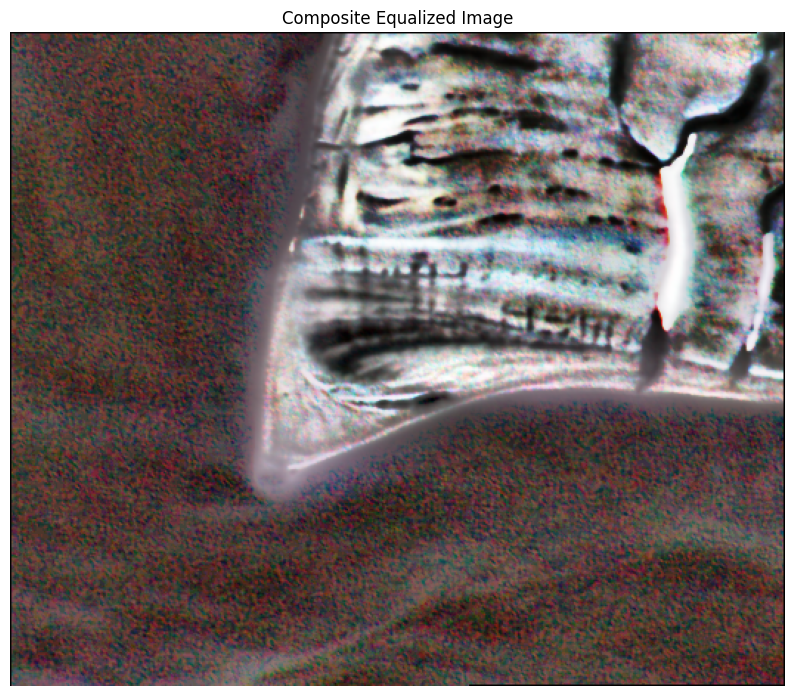

In [93]:
# Apply adaptive histogram equalization to all bands
equalized_images = []
for band in range(clipped_image.shape[0]):
    img = clipped_image[band]
    adaptiveEn = exposure.equalize_adapthist(img, clip_limit=0.08, nbins=256)
    equalized_images.append(adaptiveEn)

# Stack all equalized bands along the third dimension
stacked_equalized_image = np.stack(equalized_images, axis=-1)

# Normalize pixel values to [0, 1]
stacked_equalized_image = stacked_equalized_image / stacked_equalized_image.max()

# Create a composite RGB image
composite_image = np.zeros((stacked_equalized_image.shape[0], stacked_equalized_image.shape[1], 3))
for i in range(3):
    composite_image[:,:,i] = stacked_equalized_image[:,:,i]

# Plot the composite image
plt.figure(figsize=(10, 10))
plt.imshow(composite_image)
plt.title('Composite Equalized Image')
plt.axis('off')
plt.show()


In [96]:
import rasterio
from rasterio.transform import from_origin

# Path to save the clipped TIFF image
clipped_image_save_path = "C:\\Users\\Student\\Documents\\101_walrus_mres\\GIS\\clipped_image.tif"

# Write the clipped image data to a TIFF file
with rasterio.open(
    clipped_image_save_path,
    'w',
    driver='GTiff',
    height=clipped_image.shape[1],
    width=clipped_image.shape[2],
    count=clipped_image.shape[0],
    dtype=clipped_image.dtype,
    crs='EPSG:4326',
    transform=from_origin(left, top, xres, yres)  # Provide appropriate values
) as dst:
    dst.write(clipped_image)

# Now, you can open the saved TIFF image using rasterio
with rasterio.open(clipped_image_save_path) as dataset:
    # Read the clipped image bands
    clipped_image = dataset.read()
    # Get the metadata of the clipped image
    clipped_meta = dataset.meta


NameError: name 'left' is not defined

In [95]:
# Open the clipped image
with rasterio.open(clipped_image) as dataset:
    # Read the clipped image bands
    clipped_image = dataset.read()
    # Get the metadata of the clipped image
    clipped_meta = dataset.meta

# Now, you have the clipped image data and its metadata available for further processing


TypeError: invalid path or file: array([[[   0,    0,    0, ..., 1497, 1579,    0],
        [   0,  665,  640, ..., 1468, 1553,    0],
        [   0,  660,  635, ..., 1456, 1558,    0],
        ...,
        [   0,  640,  658, ...,  707,  712,    0],
        [   0,  633,  593, ...,  712,  727,    0],
        [   0,  718,  655, ...,    0,    0,    0]],

       [[   0,    0,    0, ..., 1615, 1704,    0],
        [   0,  583,  588, ..., 1596, 1690,    0],
        [   0,  575,  575, ..., 1548, 1656,    0],
        ...,
        [   0,  673,  673, ...,  582,  586,    0],
        [   0,  670,  668, ...,  594,  601,    0],
        [   0,  664,  661, ...,    0,    0,    0]],

       [[   0,    0,    0, ..., 1783, 1906,    0],
        [   0,  477,  475, ..., 1741, 1895,    0],
        [   0,  449,  462, ..., 1693, 1838,    0],
        ...,
        [   0,  572,  565, ...,  510,  516,    0],
        [   0,  572,  568, ...,  505,  502,    0],
        [   0,  575,  572, ...,    0,    0,    0]],

       ...,

       [[   0,    0,    0, ..., 1952, 2069,    0],
        [   0,  150,  158, ..., 1898, 2019,    0],
        [   0,  158,  143, ..., 1867, 2004,    0],
        ...,
        [   0,  180,  168, ...,  176,  183,    0],
        [   0,  167,  158, ...,  171,  173,    0],
        [   0,  150,  143, ...,    0,    0,    0]],

       [[   0,    0,    0, ..., 2103, 2144,    0],
        [   0,  134,  121, ..., 2072, 2121,    0],
        [   0,  134,  119, ..., 2040, 2100,    0],
        ...,
        [   0,  113,  132, ...,  101,   99,    0],
        [   0,  110,  122, ...,  111,  104,    0],
        [   0,   97,  104, ...,    0,    0,    0]],

       [[   0,    0,    0, ..., 2302, 2309,    0],
        [   0,   27,   16, ..., 2207, 2255,    0],
        [   0,   32,   17, ..., 2150, 2149,    0],
        ...,
        [   0,   57,   66, ...,   83,   42,    0],
        [   0,   74,   89, ...,   71,   46,    0],
        [   0,   96,   91, ...,    0,    0,    0]]], dtype=uint16)

This is me trying to debug 

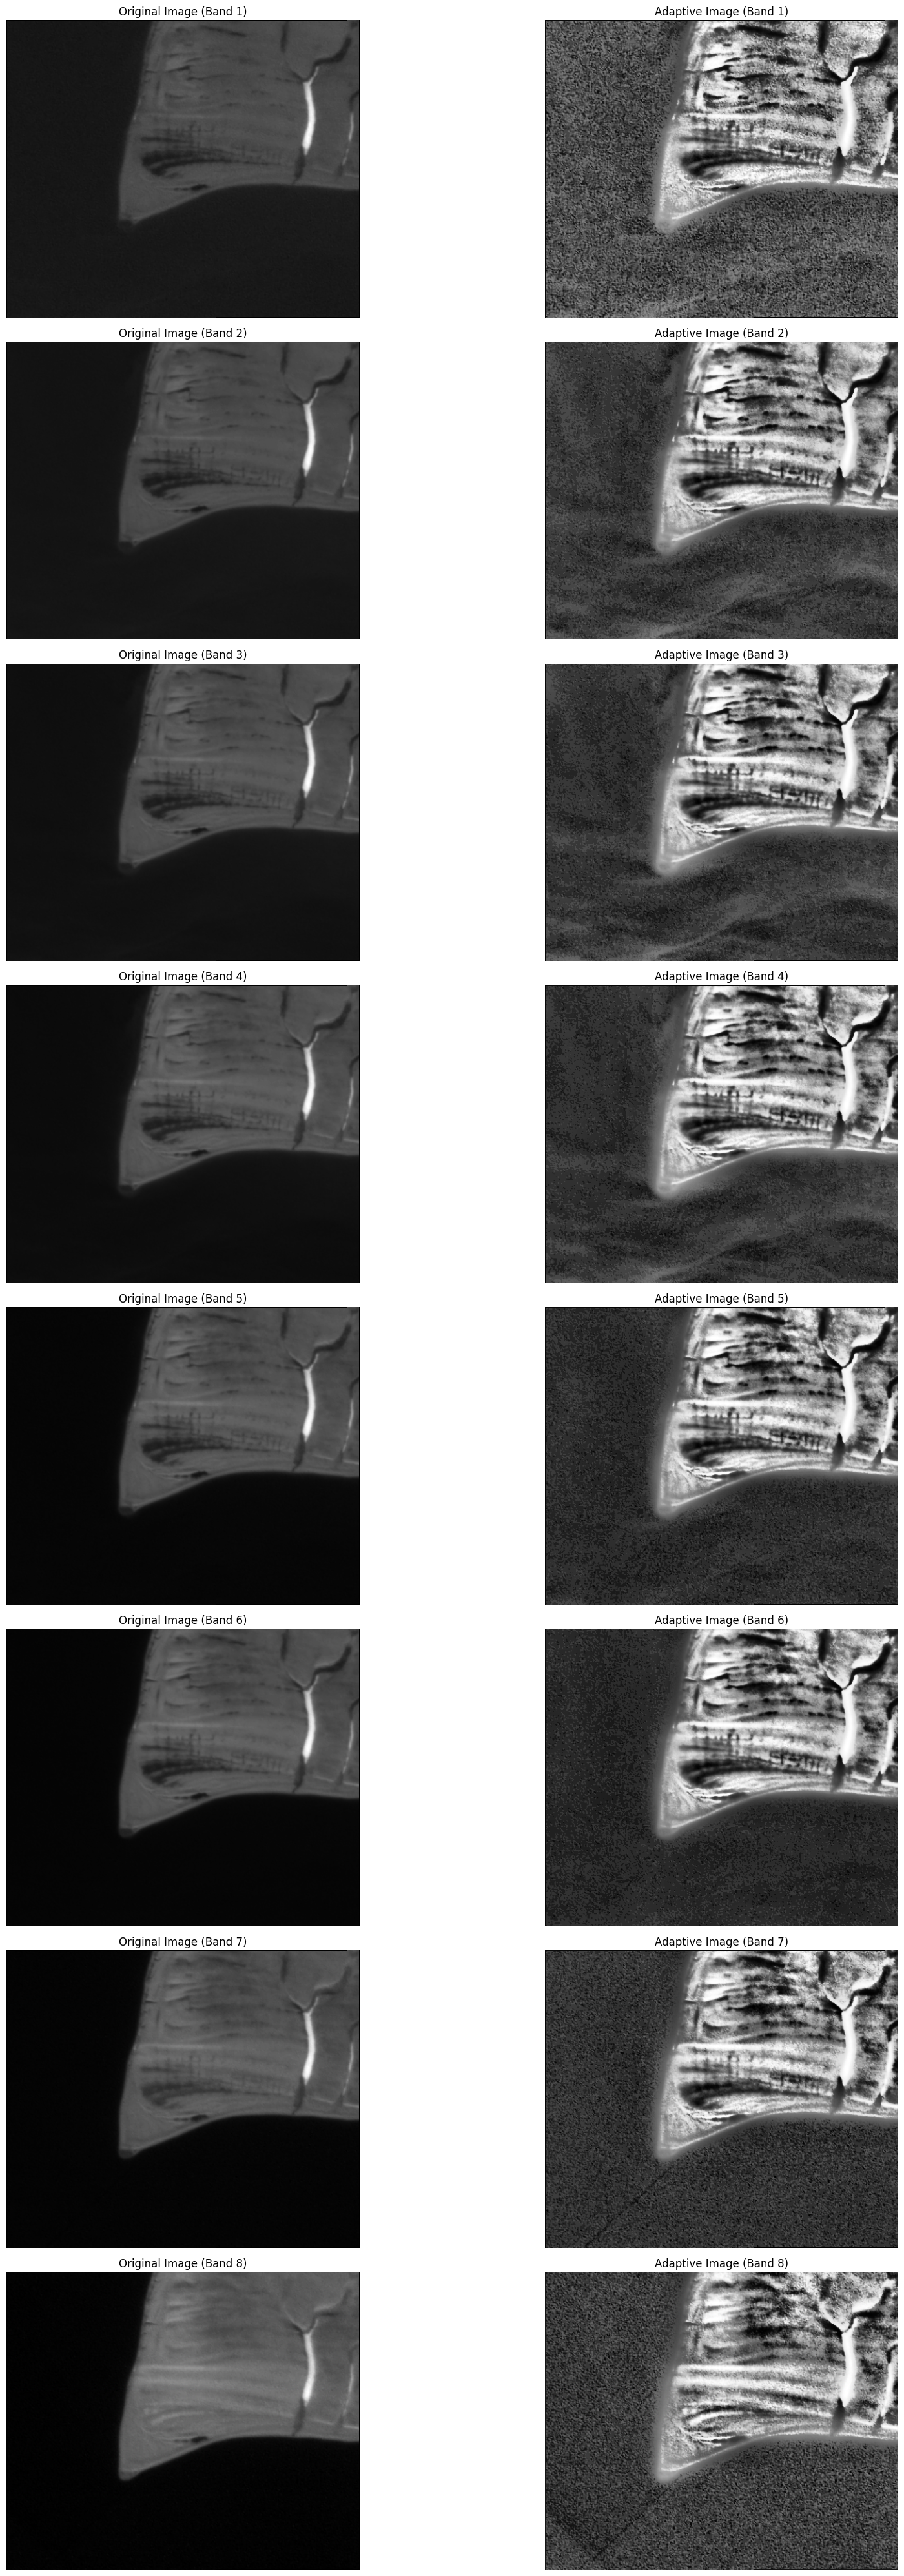

In [91]:


# Initialize a list to store the equalized bands
equalized_images = []

# Loop through each band and apply adaptive histogram equalization
for band in range(clipped_image.shape[0]):
    img = clipped_image[band]
    adaptiveEn = exposure.equalize_adapthist(img, clip_limit=0.08, nbins=256)
    equalized_images.append(adaptiveEn)

# Convert the list to a NumPy array
equalized_images = np.array(equalized_images)

# Visualize the equalized bands
fig, ax = plt.subplots(nrows=equalized_images.shape[0], ncols=2, figsize=(20, 5*equalized_images.shape[0]))

for i in range(equalized_images.shape[0]):
    # Original Image (Band i+1)
    ax[i,0].imshow(clipped_image[i], cmap='gray')
    ax[i,0].set_title(f'Original Image (Band {i+1})')
    ax[i,0].axis('off')

    # Adaptive Equalized Image (Band i+1)
    ax[i,1].imshow(equalized_images[i], cmap='gray')
    ax[i,1].set_title(f'Adaptive Image (Band {i+1})')
    ax[i,1].axis('off')

plt.tight_layout()
plt.show()


NameError: name 'land_mask' is not defined

ERROR: Could not find a version that satisfies the requirement crop_aoi_with_buffer (from versions: none)
ERROR: No matching distribution found for crop_aoi_with_buffer

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


TypeError: expected string or bytes-like object

saving the model 

In [ ]:
import joblib

# After training your model
joblib.dump(rf, 'random_forest_model.pkl')
print("Model saved to random_forest_model.pkl")


loading the model 

In [ ]:
# When you want to load the model and use it for prediction
rf = joblib.load('random_forest_model.pkl')
print("Model loaded from random_forest_model.pkl")


example 

In [ ]:
import glob
import geopandas as gpd
import rasterio
from rasterio import features
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import joblib

def get_raster_and_mask(tif_file, shp_file):
    shp_df = gpd.read_file(shp_file)
    rstr = rasterio.open(tif_file)
    shp_df = shp_df.to_crs(rstr.crs)
    
    out_arr = rstr.read()
    mask = features.rasterize(
        shapes=((geom, value) for geom, value in zip(shp_df.geometry, shp_df['Label'])),
        fill=0,
        out_shape=(rstr.height, rstr.width),
        transform=rstr.transform
    )
    return out_arr, mask

# Paths to images and shapefiles, load all together instead of separate paths
image_paths = glob.glob("path_to_images/*.tif")
shapefile_paths = glob.glob("path_to_shapefiles/*.shp")

# Initialize lists to store the combined dataset
X_list = []
y_list = []

# Load the existing model if it exists, else create a new one
try:
    rf = joblib.load('random_forest_model.pkl')
    print("Loaded existing model.")
except FileNotFoundError:
    rf = RandomForestClassifier(n_estimators=500, oob_score=True)
    print("No existing model found. Created a new one.")

# Process each image and corresponding shapefile
for image_path, shapefile_path in zip(image_paths, shapefile_paths):
    img, roi = get_raster_and_mask(image_path, shapefile_path)
    img = img.transpose(1, 2, 0)  # Reshape to (height, width, bands)
    
    X = img[roi > 0, :]  # Extract the features
    y = roi[roi > 0]     # Extract the labels
    
    X_list.append(X)
    y_list.append(y)

# Combine all data
X_combined = np.vstack(X_list)
y_combined = np.hstack(y_list)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.25, random_state=0)

# Train the model
rf.fit(X_train, y_train)

# Save the model
joblib.dump(rf, 'random_forest_model.pkl')
print("Model saved to random_forest_model.pkl")

# Evaluate the model
print(f"Our OOB prediction of accuracy is: {rf.oob_score_ * 100:.2f}%")
